# Классификация текстов с помощью модели BERT



## Загрузка данных

In [ ]:
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 34.8 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 35.0 MB/s 
     |████████████████████████████████| 6.6 MB 48.0 MB/s 
     |████████████████████████████████| 163 kB 72.5 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.14
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.1+cu113
transformers: 4.22.2



In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
df = pd.read_csv("preprocessed_dataset.csv")
# print("Количество примеров: ", df.shape[0])
df.head(10)

FileNotFoundError: ignored

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

In [ ]:
print(df['content'].fillna('').str.len().mean())

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

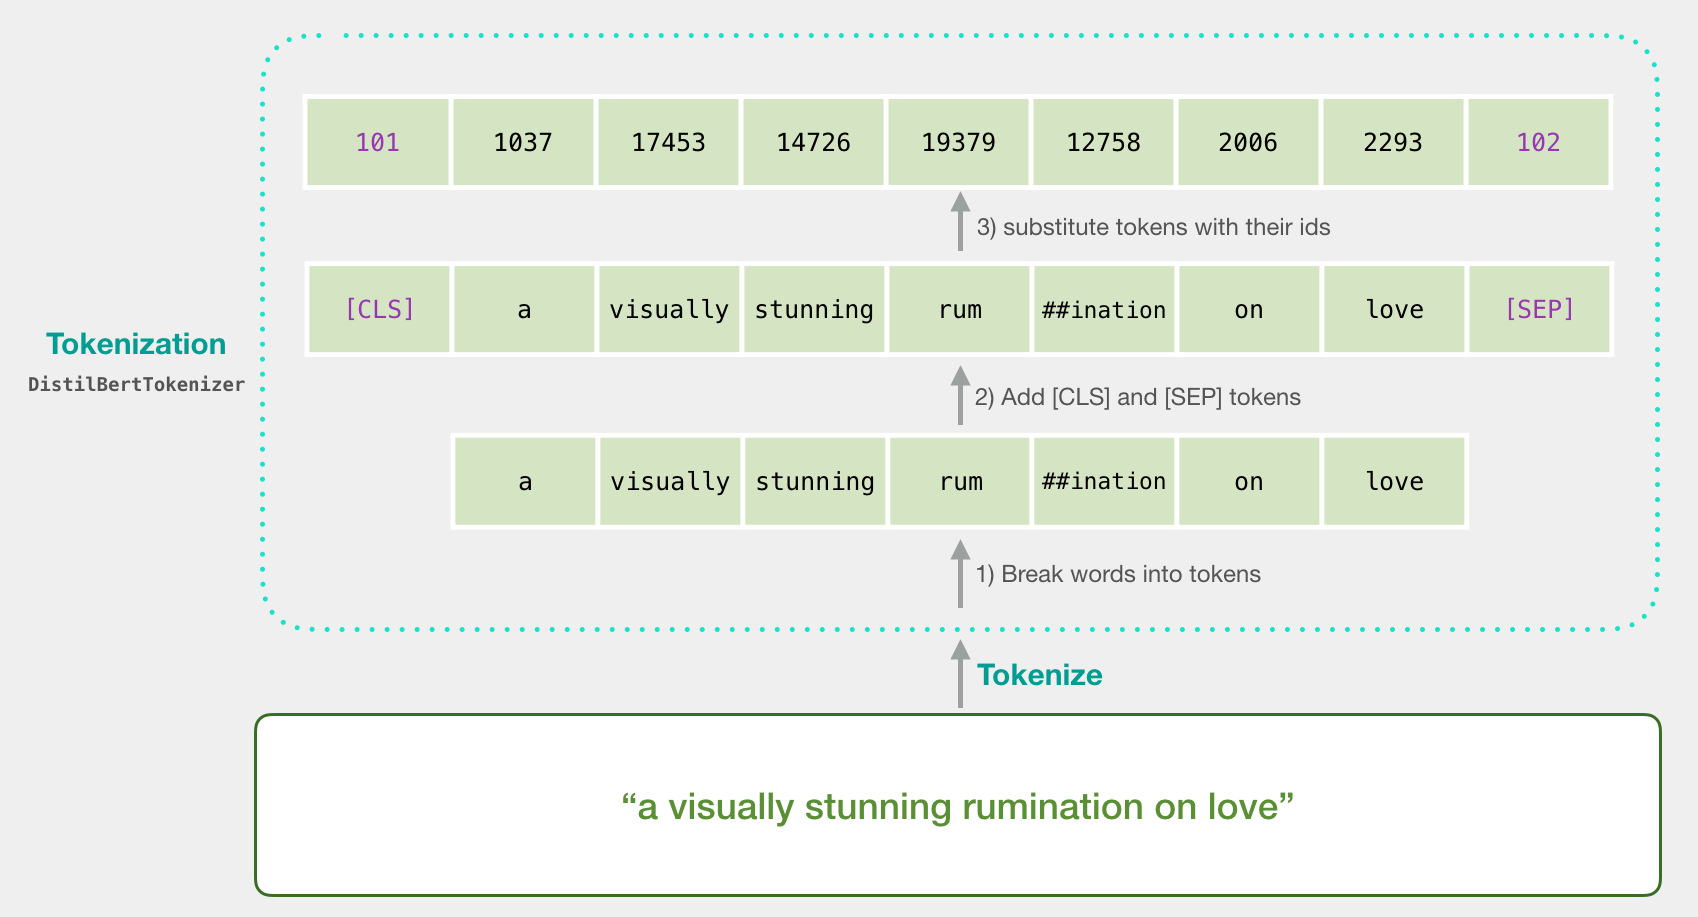

In [ ]:
PRE_TRAINED_MODEL_NAME = 'DeepPavlov/rubert-base-cased-conversational'

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-conversational")

model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-conversational")

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
sample_txt = 'He started a new book, it was quite readable'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  # pad_to_max_length=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

encoding.keys()

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

In [ ]:
df_train = df_train[:1000]

In [ ]:
df_train.shape

In [ ]:
df_val = df_val[:100]

In [ ]:
df_test = df_test[:100]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))

In [ ]:
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

## Классификация сентимента с использованием модели BERT от Hugging Face

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
outputs = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

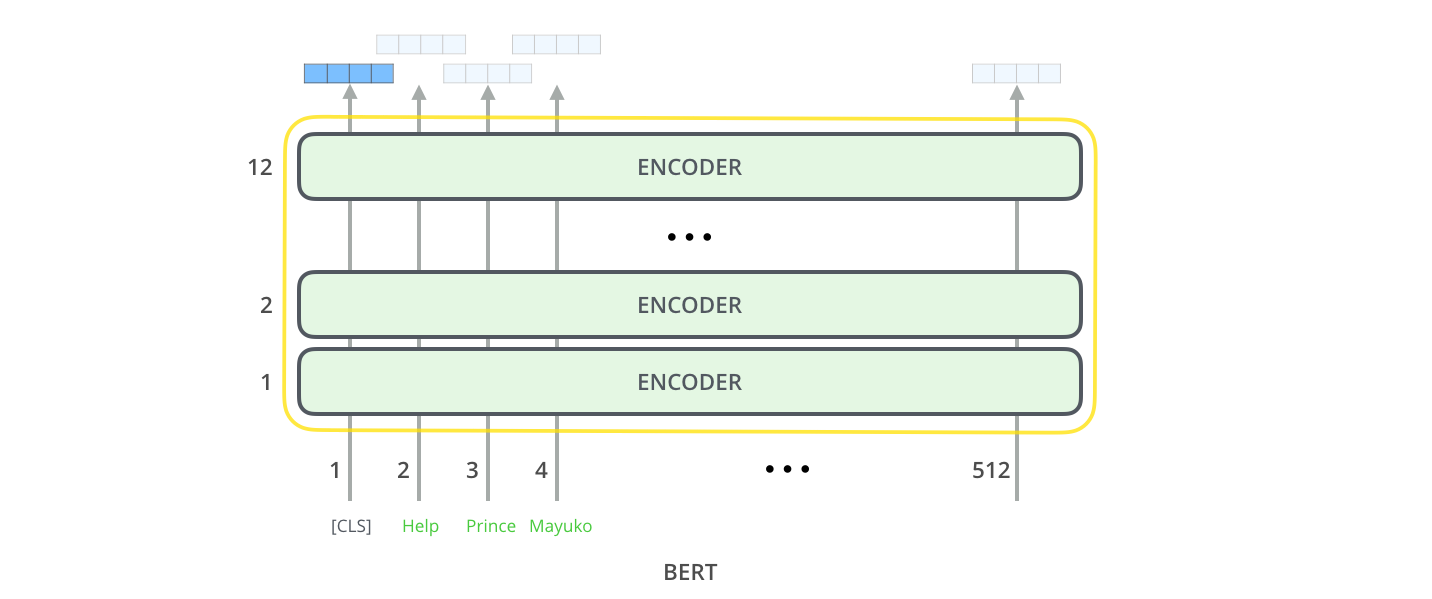

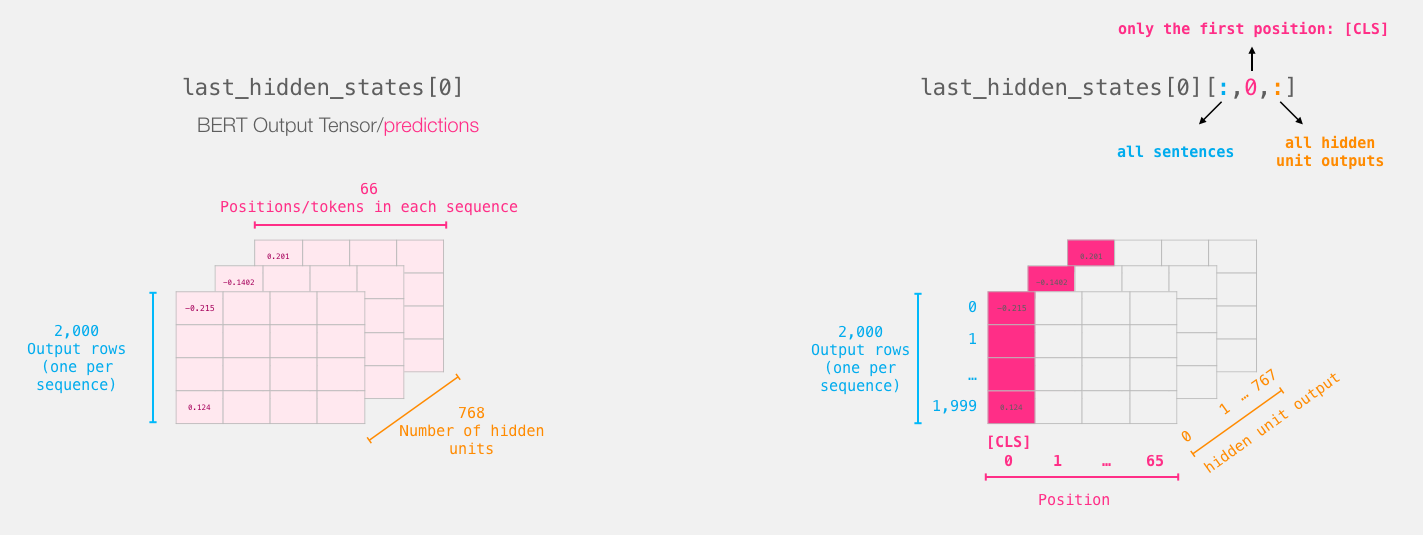

In [ ]:
outputs.keys()

In [ ]:
last_hidden_state = outputs['last_hidden_state']

In [ ]:
pooler_output = outputs['pooler_output']
print(pooler_output.shape)
print(pooler_output)

In [ ]:
last_hidden_state.shape

In [ ]:
print(df.loc[350]['content'])
print(df.loc[99]['content'])

In [ ]:
sample_txt = df.content
sample_txt = sample_txt[:10000]
sample_txt = [df.loc[350]['content'], df.loc[350]['content']]
type(sample_txt)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

In [ ]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)['last_hidden_state']

In [ ]:
last_hidden_state.shape

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('приложение')

In [ ]:
last_hidden_state

In [ ]:
emb0 = last_hidden_state[0, 4]
emb0.shape

In [ ]:
df.loc[99]['content']

In [ ]:
sample_txt = df.loc[99]['content']
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)['last_hidden_state']

In [ ]:
emb1 = last_hidden_state[0, 18]
emb1.shape

In [ ]:
emb1

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity([
    emb0.detach().cpu().numpy(),
    emb1.detach().cpu().numpy()])

#### Классификатор

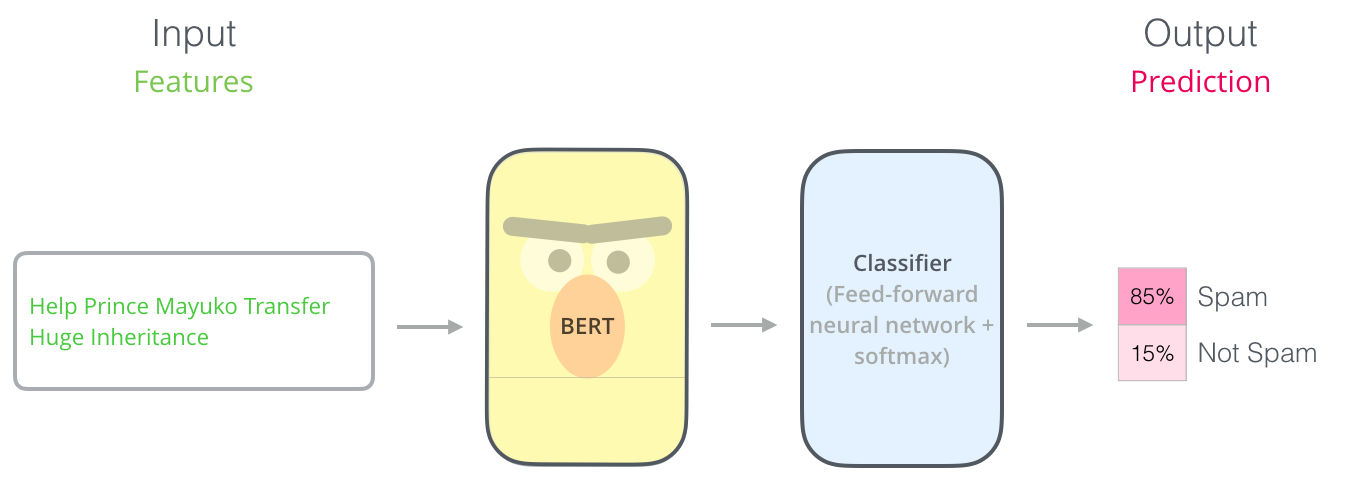

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs["pooler_output"])
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
model

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
import torch.nn.functional as F

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

## Обучение модели

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')

# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1]);

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## Оценка результатов работы модели

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

## Предсказание на произвольных текстах

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
sample_txt = df.loc[99]['content']
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)
encoding = encoding.to(device)
last_hidden_state = model.bert(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)["last_hidden_state"]
idx0 = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('помойка')
emb0 = last_hidden_state[0, idx0]

In [ ]:
sample_txt = df.loc[350]['content']
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)
encoding = encoding.to(device)
last_hidden_state = model.bert(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)["last_hidden_state"]
idx1 = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('приложение')
emb1 = last_hidden_state[0, idx1]

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
cosine_similarity([
    emb0.detach().cpu().numpy(),
    emb1.detach().cpu().numpy()])

In [ ]:
%%time
sentences = df.content.dropna().tolist()
sentences = sentences[:500]
print(len(sentences))
tokenizer_result = tokenizer(sentences, 
                             max_length=32,
                             add_special_tokens=True,
                             return_token_type_ids=False,
                             pad_to_max_length=True,
                             return_attention_mask=True, 
                             return_tensors='pt')

input_ids = tokenizer_result.input_ids
attention_mask = tokenizer_result.attention_mask

print(input_ids.shape) 

print(input_ids)

print(attention_mask.shape)

print(attention_mask)

model_result = bert_model(input_ids, attention_mask=attention_mask, return_dict=True)

token_embeddings = model_result.last_hidden_state
print(token_embeddings.shape) 

NameError: ignored

In [ ]:
!pip install datasets

     |████████████████████████████████| 270 kB 7.9 MB/s 
     |████████████████████████████████| 125 kB 66.4 MB/s 
     |████████████████████████████████| 1.3 MB 58.0 MB/s 
     |████████████████████████████████| 243 kB 75.7 MB/s 
     |████████████████████████████████| 160 kB 71.9 MB/s 
     |████████████████████████████████| 271 kB 73.4 MB/s 


In [ ]:
from datasets import load_dataset

imdb_dataset = load_dataset('imdb')

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
imdb_dataset["train"]["text"][:10]

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
 'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything fro

In [ ]:
imdb_dataset["train"]["label"][:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
train_texts = imdb_dataset["train"]["text"][:2000]
train_labels = imdb_dataset["train"]["label"][:2000]
test_texts = imdb_dataset["test"]["text"][:1000]
test_labels = imdb_dataset["test"]["label"][:1000]

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Step,Training Loss
10,0.687800
20,0.655400
30,0.583800
40,0.459700
50,0.294800
60,0.149200
70,0.066300
80,0.030300
90,0.017100
100,0.011000




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=200, training_loss=0.14950116618070752, metrics={'train_runtime': 87.0915, 'train_samples_per_second': 36.743, 'train_steps_per_second': 2.296, 'total_flos': 423895675699200.0, 'train_loss': 0.14950116618070752, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 400
  Batch size = 64


{'epoch': 2.0,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_loss': 0.0009513614932075143,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_runtime': 3.4249,
 'eval_samples_per_second': 116.792,
 'eval_steps_per_second': 2.044}

In [ ]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'epoch': 2.0,
 'test_accuracy': 1.0,
 'test_f1': 1.0,
 'test_loss': 0.0009546226356178522,
 'test_precision': 1.0,
 'test_recall': 1.0,
 'test_runtime': 8.4862,
 'test_samples_per_second': 117.838,
 'test_steps_per_second': 1.885}